In [1]:
import cv2
import math
import numpy as np
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import os
import platform

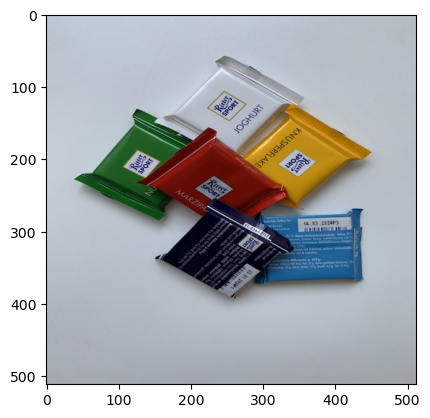

In [13]:
if platform.system() == "Windows":
    image = cv2.imread(r"data\IMG_3628.png")
else:
    image = cv2.imread(r"data/IMG_3628.png")
image = cv2.resize(image, (512, 512)) 
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [14]:
def auto_canny_edge_detection(image, sigma=0.33):
    md = np.median(image)
    lower_value = int(max(0, (1.0 - sigma) * md))
    upper_value = int(min(255, (1.0 + sigma) * md))
    return cv2.Canny(image, lower_value, upper_value)

In [15]:
image_auto_edged = auto_canny_edge_detection(image)
image_with_lines = cv2.cvtColor(image_auto_edged, cv2.COLOR_GRAY2BGR)

Text(0.5, 1.0, 'Edge Detection')

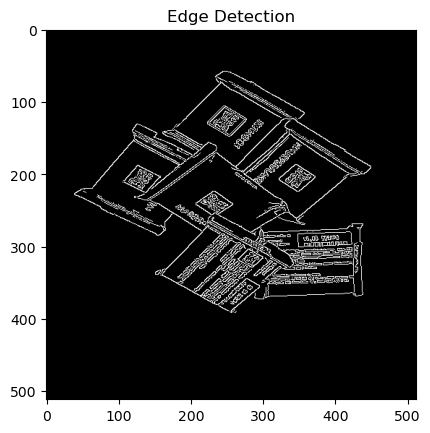

In [16]:
plt.imshow(cv2.cvtColor(image_auto_edged, cv2.COLOR_BGR2RGB))
plt.title("Edge Detection")

In [17]:
linesP = cv2.HoughLinesP(image_auto_edged, 1, np.pi / 180, 30, 3, 30, 8)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(image_with_lines, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)

number_of_lines = len(linesP)
print("Anzahl der erkannten Linien: " + str(number_of_lines))

Anzahl der erkannten Linien: 211


Text(0.5, 1.0, 'Hough Lines')

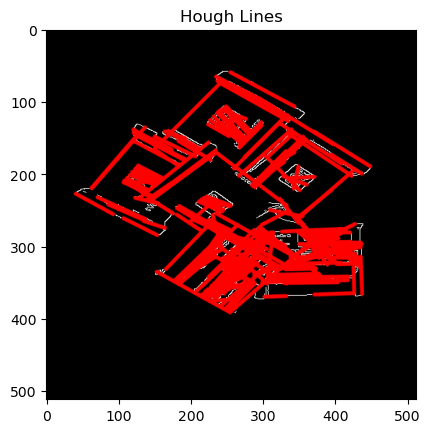

In [18]:
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title("Hough Lines")

In [19]:
def detect_contour(image, blurred_image):
    edged = cv2.Canny(blurred_image, 10, 100)
    auto_edge = auto_canny_edge_detection(blurred_image)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.dilate(edged, kernel, iterations=1)
    erosion = cv2.erode(dilate, kernel, iterations=1)
    nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(erosion)
    sizes = stats[:, -1]
    sizes = sizes[1:]
    nb_blobs -= 1
    min_size = 750
    # output image with only the kept components
    result_image = np.zeros_like(im_with_separated_blobs)
    area_of_all_contours = 0
    # for every component in the image, keep it only if it's above min_size
    for blob in range(nb_blobs):
        if sizes[blob] >= min_size:
            result_image[im_with_separated_blobs == blob + 1] = 255
            area_of_all_contours = area_of_all_contours + sizes[blob]

    result_image = result_image.astype(np.uint8)
    # find the contours in the dilated image
    contours, _ = cv2.findContours(result_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_copy = image.copy()
    # draw the contours on a copy of the original image
    cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
    return area_of_all_contours, len(contours), image_copy

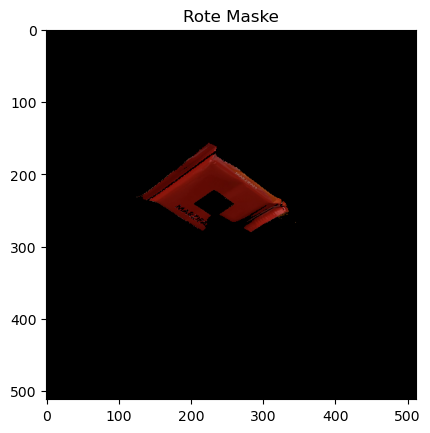

In [20]:
contours = 0
contours_size = 0
j = 1
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
red_mask = cv2.inRange(hsv, (0, 100, 72), (13, 255, 255))
yellow_mask = cv2.inRange(hsv, (15, 146, 90), (28, 255, 255))
blue_mask = cv2.inRange(hsv, (100, 158, 70), (111, 255, 185))
green_mask = cv2.inRange(hsv, (56, 128, 33), (89, 255, 104))
#white_mask = cv2.inRange(hsv, (104, 23, 128), (116, 32, 180))
darkblue_mask = cv2.inRange(hsv, (103, 46, 0), (168, 255, 80))
masks = [darkblue_mask, yellow_mask, blue_mask, green_mask, red_mask]
Masksname = ["Nichts", "Dunkelblaue Maske", "Gelbe Maske", "Blaue Maske", "Grüne Maske", "Rote Maske"]
for mask in masks:
    imask = mask > 0
    coloured_image = np.zeros_like(image, np.uint8)
    coloured_image[imask] = image[imask]
    size_of_contours, number_of_contours, result_image = detect_contour(image, coloured_image)
    contours = contours + number_of_contours
    contours_size = contours_size + size_of_contours
    coloured_image = cv2.cvtColor(coloured_image, cv2.COLOR_BGR2RGB)
    plt.imshow(coloured_image)
    plt.title(Masksname[j])
    j=j+1

number_of_contours = contours
area_of_all_contours = contours_size


Anzahl der erkannten Konturen: 5
Fläche der erkannten Konturen: 21473


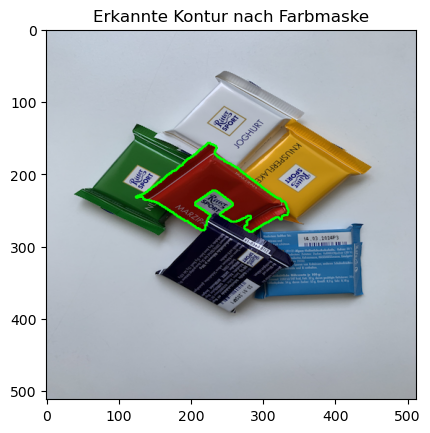

In [21]:
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title("Erkannte Kontur nach Farbmaske")

print("Anzahl der erkannten Konturen: " + str(number_of_contours))
print("Fläche der erkannten Konturen: " + str(area_of_all_contours))

In [22]:
test_features = [number_of_lines, number_of_contours, area_of_all_contours]
print(test_features)

[211, 5, 21473]
